# Data Augmentation Examples

This notebook visualizes the different augmentation levels (light, medium, heavy) applied to sample images from the HAM10000 dataset.

This helps understand how each augmentation strategy transforms the images during training.

In [1]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [2]:
def get_augmentation_transforms(augmentation_level="medium", input_size=224):
    """
    Create augmentation transforms based on research best practices.

    Args:
        augmentation_level: 'light', 'medium', or 'heavy'
        input_size: Target image size (224 or 299)
    """

    # Base transforms for validation/testing (no augmentation)
    no_augmentation = transforms.Compose(
        [
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
        ]
    )

    # Training transforms with varying augmentation levels
    if augmentation_level == "light":
        train_transform = transforms.Compose(
            [
                transforms.Resize((input_size, input_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ToTensor(),
            ]
        )

    elif augmentation_level == "medium":
        train_transform = transforms.Compose(
            [
                transforms.Resize((input_size, input_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(20),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
            ]
        )

    else:  # heavy
        train_transform = transforms.Compose(
            [
                transforms.Resize((int(input_size * 1.1), int(input_size * 1.1))),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
                transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
                transforms.ToTensor(),
            ]
        )

    return train_transform, no_augmentation

In [3]:
# Get sample images from the dataset
image_dir = "data/ham10000/ds/img"
ann_dir = "data/ham10000/ds/ann"

# Get all image files
all_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
print(f"Total images found: {len(all_files)}")

# Class mapping
group_map = {
    "melanoma": "melanoma",
    "basal cell carcinoma": "suspicious",
    "actinic keratoses": "suspicious",
    "melanocytic nevi": "benign",
    "benign keratosis-like lesions": "benign",
    "dermatofibroma": "benign",
    "vascular lesions": "benign",
}

# Select one sample from each class
samples_by_class = {"benign": None, "suspicious": None, "melanoma": None}

for img_file in all_files:
    ann_path = os.path.join(ann_dir, img_file + ".json")
    try:
        with open(ann_path, "r") as f:
            ann = json.load(f)
        original_label = ann["objects"][0]["classTitle"]
        group_label = group_map[original_label]

        if samples_by_class[group_label] is None:
            samples_by_class[group_label] = img_file

        # Break if we have all three classes
        if all(v is not None for v in samples_by_class.values()):
            break
    except:
        continue

print("\nSelected samples:")
for class_name, img_file in samples_by_class.items():
    print(f"  {class_name}: {img_file}")

Total images found: 10015

Selected samples:
  benign: ISIC_0024306.jpg
  suspicious: ISIC_0024329.jpg
  melanoma: ISIC_0024310.jpg


In [4]:
def show_augmentation_examples(image_path, class_name, input_size=224, num_examples=3):
    """
    Display original image and augmented versions for each augmentation level.

    Args:
        image_path: Path to the image file
        class_name: Class label for the image
        input_size: Target image size
        num_examples: Number of augmented examples per level
    """
    # Load original image
    original_image = Image.open(image_path).convert("RGB")

    # Get transforms for each level
    light_transform, _ = get_augmentation_transforms("light", input_size)
    medium_transform, _ = get_augmentation_transforms("medium", input_size)
    heavy_transform, _ = get_augmentation_transforms("heavy", input_size)
    no_aug_transform = transforms.Compose(
        [
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
        ]
    )

    # Create figure
    fig, axes = plt.subplots(4, num_examples + 1, figsize=(20, 16))
    fig.suptitle(f"Augmentation Examples - {class_name.upper()}", fontsize=20, fontweight="bold")

    augmentation_levels = [
        ("Original (No Augmentation)", no_aug_transform),
        ("Light Augmentation", light_transform),
        ("Medium Augmentation", medium_transform),
        ("Heavy Augmentation", heavy_transform),
    ]

    for row_idx, (aug_name, transform) in enumerate(augmentation_levels):
        # Set row label
        axes[row_idx, 0].text(
            -0.1,
            0.5,
            aug_name,
            transform=axes[row_idx, 0].transAxes,
            fontsize=14,
            fontweight="bold",
            verticalalignment="center",
            rotation=90,
        )

        # Show original or augmented examples
        for col_idx in range(num_examples + 1):
            if row_idx == 0 and col_idx > 0:
                # For original row, show same image
                img_tensor = no_aug_transform(original_image)
            else:
                # Apply augmentation
                img_tensor = transform(original_image)

            # Convert tensor to numpy for display
            img_np = img_tensor.permute(1, 2, 0).numpy()

            # Display
            axes[row_idx, col_idx].imshow(img_np)
            axes[row_idx, col_idx].axis("off")

            # Add column title for first row
            if row_idx == 0:
                if col_idx == 0:
                    axes[row_idx, col_idx].set_title("Reference", fontsize=12, fontweight="bold")
                else:
                    axes[row_idx, col_idx].set_title(f"Example {col_idx}", fontsize=12)

    plt.tight_layout()
    plt.savefig(f"augmentation_examples_{class_name}.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f"\nSaved: augmentation_examples_{class_name}.png")

## Augmentation Examples by Class

Below we show how each augmentation level affects images from different classes:

### Augmentation Levels:

**1. Light Augmentation:**
- Random horizontal flip (50%)
- Random vertical flip (50%)

**2. Medium Augmentation:**
- Horizontal & vertical flips (50%)
- Random rotation (±20°)
- Color jitter (brightness, contrast, saturation, hue)

**3. Heavy Augmentation:**
- All medium transforms
- Stronger rotation (±30°)
- Random affine (translation, scaling)
- Stronger color jitter
- Random resized crop


Generating augmentation examples for: BENIGN


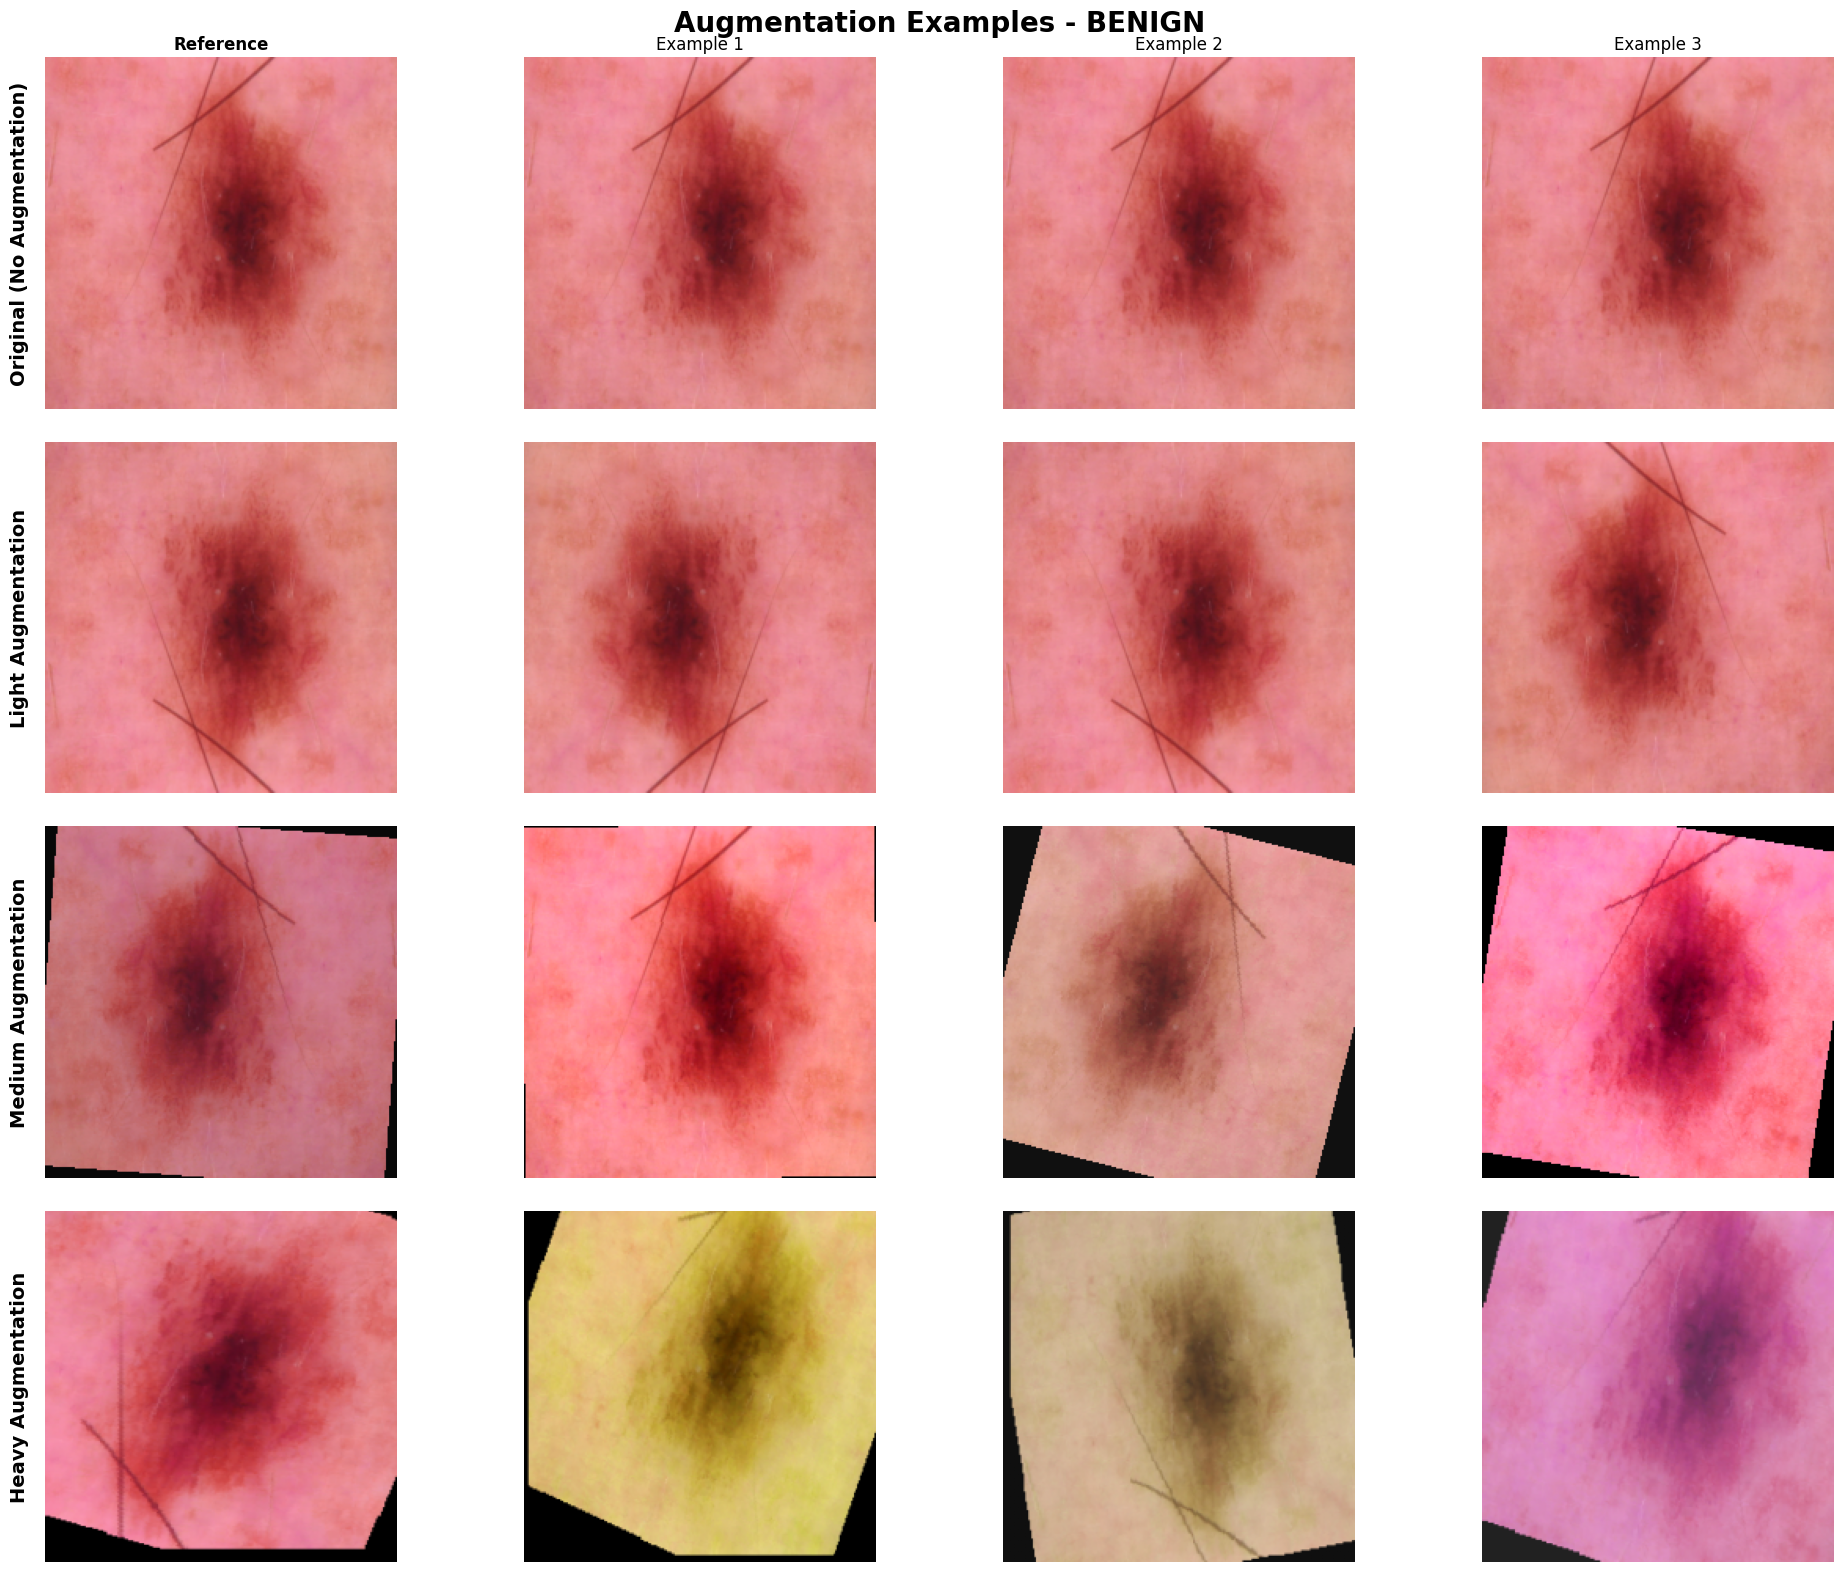


Saved: augmentation_examples_benign.png

Generating augmentation examples for: SUSPICIOUS


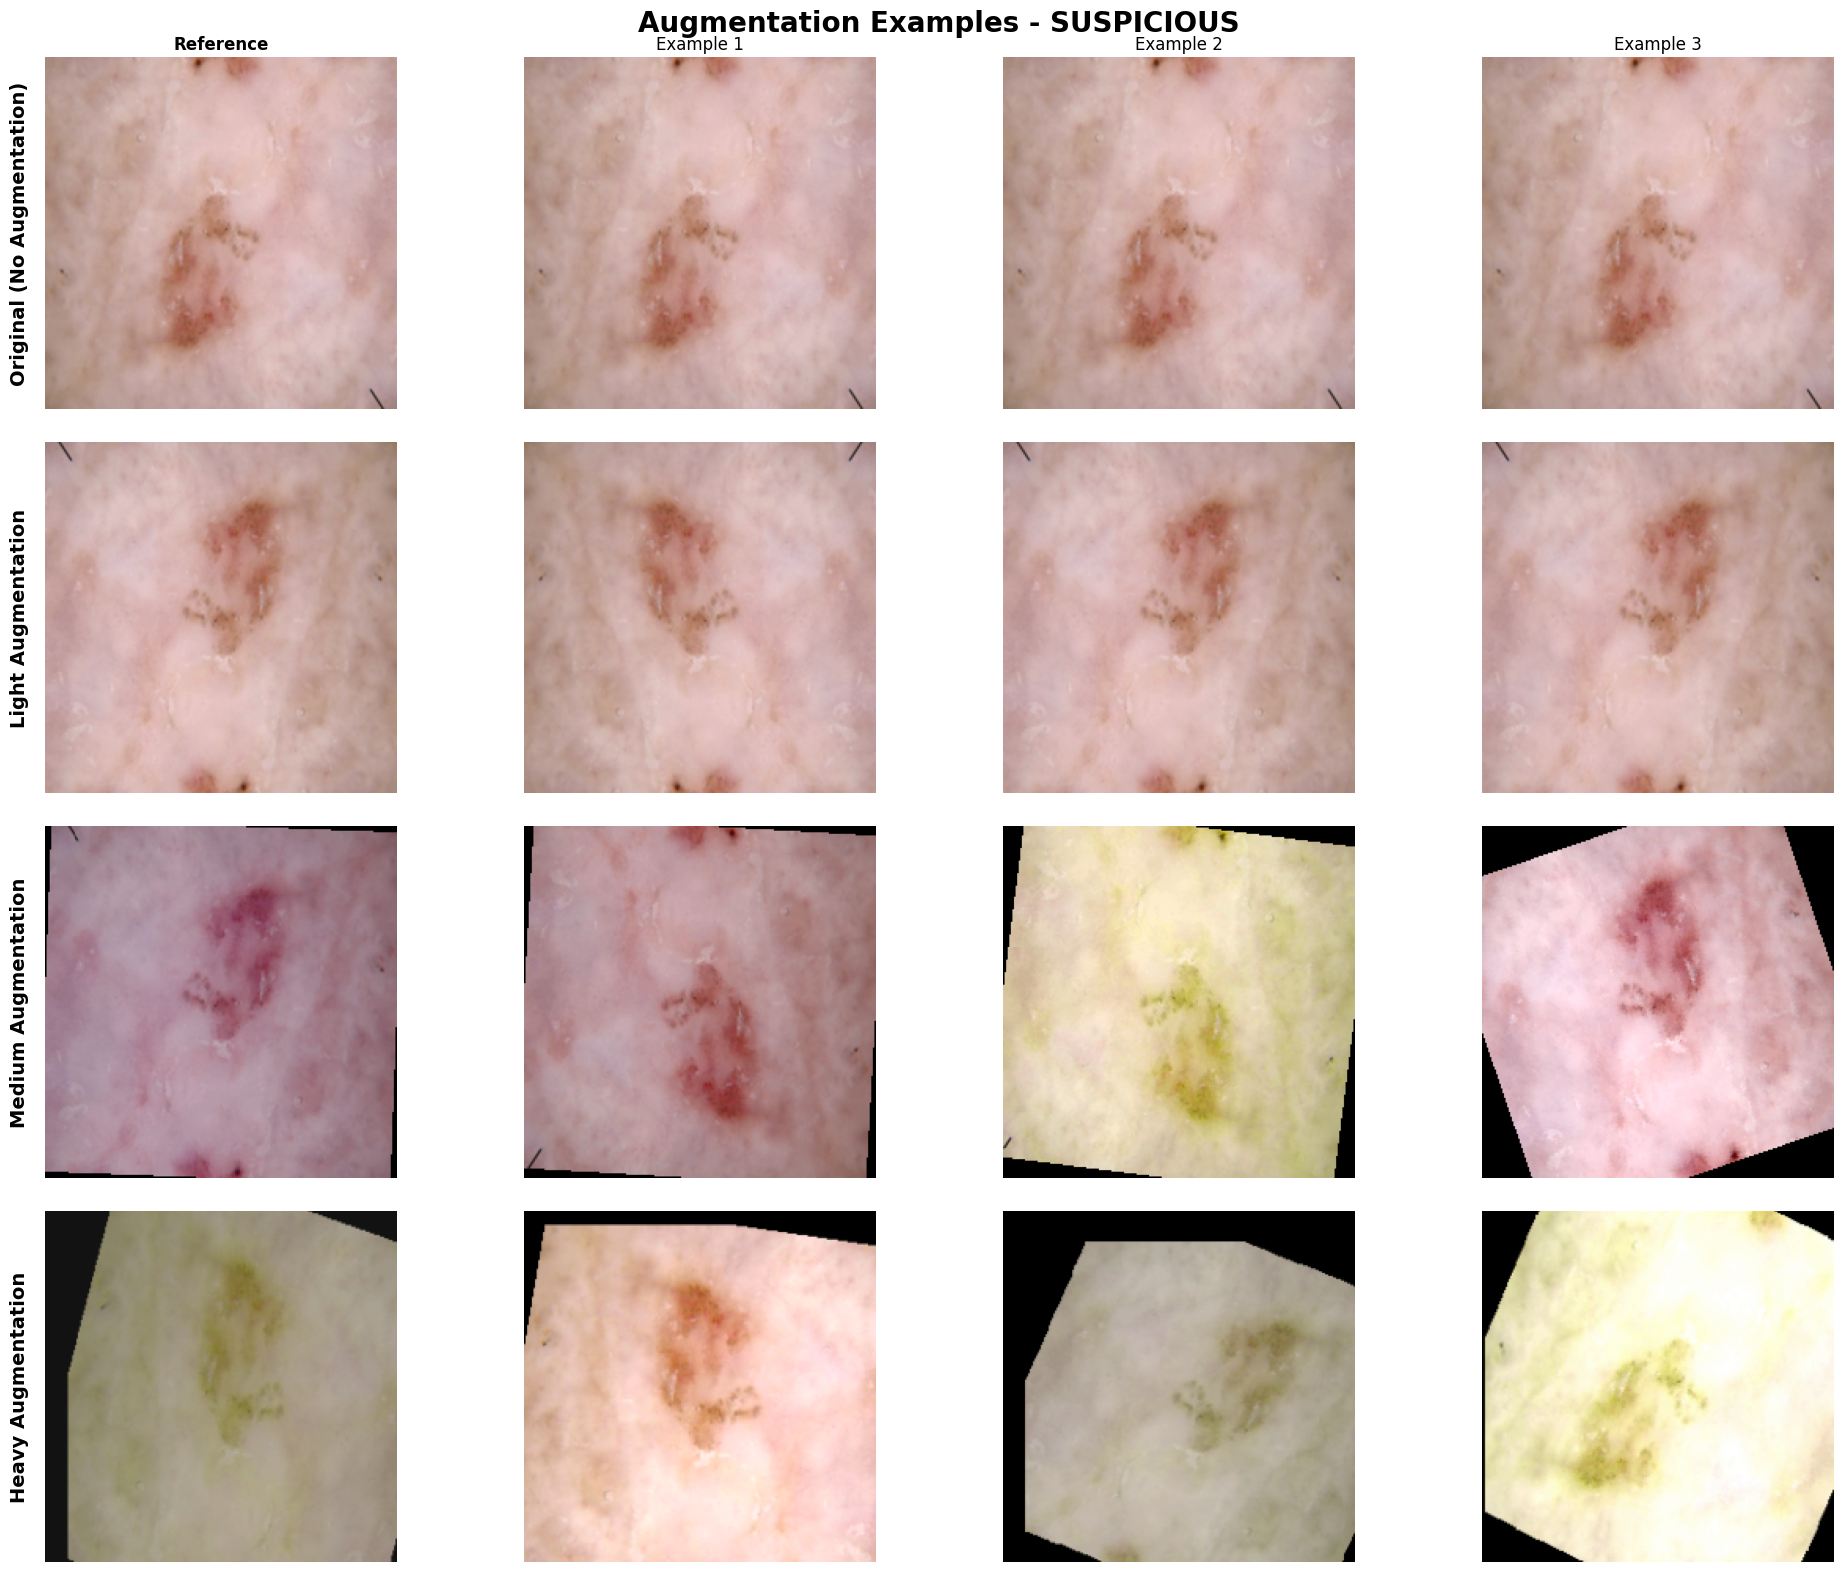


Saved: augmentation_examples_suspicious.png

Generating augmentation examples for: MELANOMA


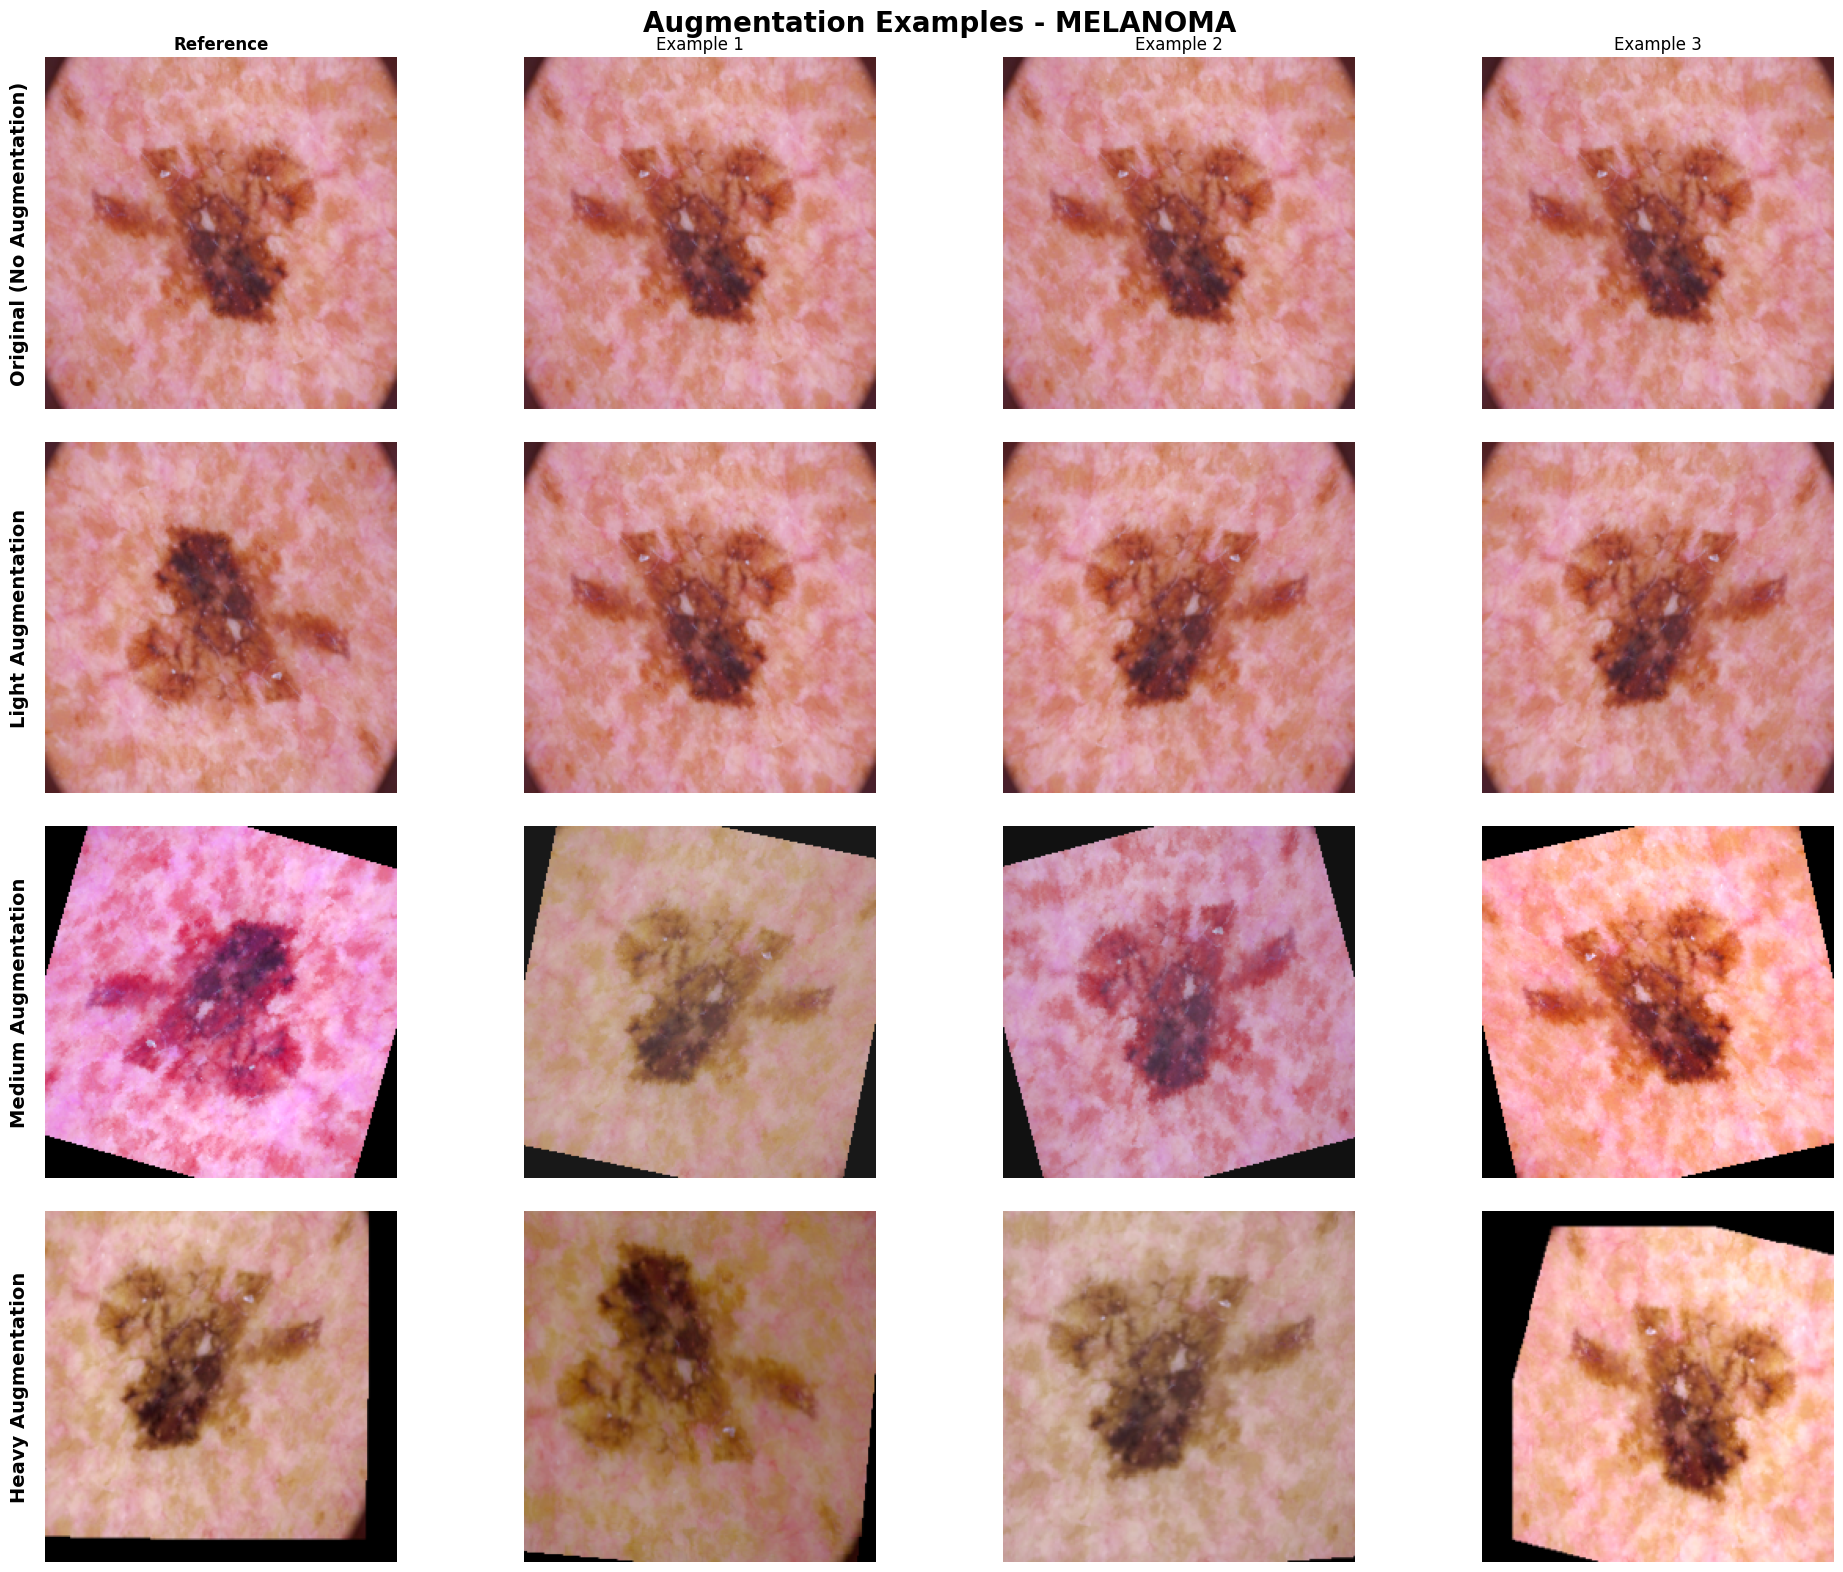


Saved: augmentation_examples_melanoma.png


In [5]:
# Generate examples for each class
for class_name, img_file in samples_by_class.items():
    if img_file is not None:
        img_path = os.path.join(image_dir, img_file)
        print(f"\n{'='*70}")
        print(f"Generating augmentation examples for: {class_name.upper()}")
        print(f"{'='*70}")
        show_augmentation_examples(img_path, class_name, input_size=224, num_examples=3)

## Augmentation Strategy Comparison

### Key Observations:

**Light Augmentation:**
- ✅ Preserves original image characteristics
- ✅ Minimal distortion
- ⚠️ Limited variation for model training
- **Use case**: When you have lots of data or need to preserve fine details

**Medium Augmentation:**
- ✅ Good balance between variation and realism
- ✅ Rotation helps with orientation invariance
- ✅ Color jitter handles lighting variations
- **Use case**: Default choice for medical imaging (recommended)

**Heavy Augmentation:**
- ✅ Maximum variation for robust learning
- ✅ Helps prevent overfitting with limited data
- ⚠️ May distort important features
- ⚠️ Cropping might remove lesion boundaries
- **Use case**: Small datasets or when model overfits easily

### Clinical Considerations:

For melanoma detection:
- **Rotation & Flips**: ✅ Good (lesions can appear in any orientation)
- **Color Jitter**: ✅ Good (handles different imaging conditions)
- **Random Crop**: ⚠️ Use carefully (might crop important lesion features)
- **Heavy Affine**: ⚠️ Risk distorting diagnostic features (shapes, borders)

**Recommendation**: Start with **medium augmentation** and use Optuna to find the optimal level for your specific dataset.

In [6]:
print("\n" + "=" * 70)
print("AUGMENTATION EXAMPLES COMPLETE")
print("=" * 70)
print("\nGenerated images saved as:")
for class_name in samples_by_class.keys():
    print(f"  - augmentation_examples_{class_name}.png")
print("\nThese visualizations help understand how augmentation affects")
print("the training data and can guide hyperparameter selection.")


AUGMENTATION EXAMPLES COMPLETE

Generated images saved as:
  - augmentation_examples_benign.png
  - augmentation_examples_suspicious.png
  - augmentation_examples_melanoma.png

These visualizations help understand how augmentation affects
the training data and can guide hyperparameter selection.
